# NYC出租车行程时长预测 - 完整分析

> 基于线性回归的端到端机器学习项目

**项目目标**: 预测纽约市出租车行程时长

**技术栈**: Python, Pandas, Scikit-learn, XGBoost

---

## 📋 目录

1. [环境准备与导入](#1-环境准备与导入)
2. [数据加载](#2-数据加载)
3. [数据预处理](#3-数据预处理)
4. [探索性数据分析](#4-探索性数据分析)
5. [特征工程](#5-特征工程)
6. [模型训练](#6-模型训练)
7. [模型评估](#7-模型评估)
8. [结果总结](#8-结果总结)

## 1. 环境准备与导入

导入所需的库和自定义模块

In [10]:
# 系统和路径
import sys
from pathlib import Path

# 数据处理
import numpy as np
import pandas as pd

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 设置显示选项
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 忽略警告
import warnings
warnings.filterwarnings('ignore')

print("✓ 库导入成功")

✓ 库导入成功


In [2]:
# 导入项目模块
import config
from src.utils import setup_logger, Timer
from src.data_loader import load_train_data, generate_sample_data
from src.data_preprocessing import preprocess_data, split_features_target
from src.feature_engineering import engineer_features, select_features
from src.model_training import ModelTrainer, compare_models
from src.model_evaluation import ModelEvaluator
from src.visualization import (
    plot_distribution, plot_correlation_heatmap, plot_geo_scatter,
    plot_time_series, plot_predictions, plot_residuals, plot_feature_importance
)

# 设置日志
logger = setup_logger("NYC_Taxi", config.LOG_FILE, "INFO")

print("✓ 项目模块导入成功")
print(f"项目根目录: {config.BASE_DIR}")

✓ 项目模块导入成功
项目根目录: /Users/lyh/Desktop/ Machine Learning/supervised_learning/projects/03_nyc_taxi_duration_prediction


## 2. 数据加载

加载NYC出租车数据集（或生成模拟数据用于演示）

In [3]:
# 配置参数
USE_SAMPLE = True  # 是否使用样本数据（快速演示）
SAMPLE_SIZE = 5000  # 样本大小

# 加载数据
print("="*60)
print("阶段 1/7: 数据加载")
print("="*60)

df = load_train_data(use_sample=USE_SAMPLE, sample_size=SAMPLE_SIZE)

print(f"\n数据形状: {df.shape}")
print(f"样本数量: {len(df):,}")
print(f"特征数量: {df.shape[1]}")

2025-11-12 19:41:09 - NYC_Taxi - INFO - ============================================================
2025-11-12 19:41:09 - NYC_Taxi - INFO - 加载训练数据
2025-11-12 19:41:09 - NYC_Taxi - INFO - ============================================================
2025-11-12 19:41:09 - NYC_Taxi - INFO - 开始 加载数据: nyc_taxi_train.csv...
2025-11-12 19:41:09 - NYC_Taxi - INFO - 数据加载成功: 5000 行 × 11 列
2025-11-12 19:41:09 - NYC_Taxi - INFO - 内存使用从 0.24 MB 减少到 0.22 MB (减少 7.8%)
2025-11-12 19:41:09 - NYC_Taxi - INFO - 加载数据: nyc_taxi_train.csv 完成，耗时: 0.03秒
2025-11-12 19:41:09 - NYC_Taxi - INFO - ============================================================
2025-11-12 19:41:09 - NYC_Taxi - INFO - 训练数据 基本信息
2025-11-12 19:41:09 - NYC_Taxi - INFO - ============================================================
2025-11-12 19:41:09 - NYC_Taxi - INFO - 形状: 5000 行 × 11 列
2025-11-12 19:41:09 - NYC_Taxi - INFO - 内存使用: 0.50 MB
2025-11-12 19:41:09 - NYC_Taxi - INFO - 
数据类型分布:
2025-11-12 19:41:09 - NYC_Taxi - INFO - float32    

阶段 1/7: 数据加载

数据形状: (5000, 11)
样本数量: 5,000
特征数量: 11


In [4]:
# 查看数据前5行
print("\n数据预览:")
df.head()


数据预览:


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.9822,40.7679,-73.9646,40.7656,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.9804,40.7386,-73.9995,40.7312,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.9790,40.7639,-74.0053,40.7101,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.0100,40.7200,-74.0123,40.7067,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.9731,40.7932,-73.9729,40.7825,N,435


In [5]:
# 数据基本信息
print("\n数据信息:")
df.info()


数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5000 non-null   object        
 1   vendor_id           5000 non-null   int8          
 2   pickup_datetime     5000 non-null   datetime64[ns]
 3   dropoff_datetime    5000 non-null   datetime64[ns]
 4   passenger_count     5000 non-null   int8          
 5   pickup_longitude    5000 non-null   float32       
 6   pickup_latitude     5000 non-null   float32       
 7   dropoff_longitude   5000 non-null   float32       
 8   dropoff_latitude    5000 non-null   float32       
 9   store_and_fwd_flag  5000 non-null   category      
 10  trip_duration       5000 non-null   int32         
dtypes: category(1), datetime64[ns](2), float32(4), int32(1), int8(2), object(1)
memory usage: 229.6+ KB


In [6]:
# 数值特征统计
print("\n数值特征统计:")
df.describe()


数值特征统计:


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,5000.0000,5000,5000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000
mean,1.5252,2016-04-02 13:50:46.313599744,2016-04-02 14:06:09.664000,1.6738,-73.9733,40.7508,-73.9731,40.7516,923.3504
min,1.0000,2016-01-01 00:09:03,2016-01-01 00:19:25,1.0000,-74.2099,40.6128,-74.3078,40.5673,2.0000
25%,1.0000,2016-02-17 16:39:25.500000,2016-02-17 17:08:36,1.0000,-73.9917,40.7375,-73.9911,40.7348,395.0000
50%,2.0000,2016-04-03 00:19:51,2016-04-03 00:36:13.500000,1.0000,-73.9817,40.7547,-73.9795,40.7548,656.5000
75%,2.0000,2016-05-17 18:26:13.500000,2016-05-17 18:38:27.750000128,2.0000,-73.9670,40.7680,-73.9626,40.7704,1054.7500
max,2.0000,2016-06-30 23:34:53,2016-06-30 23:54:08,6.0000,-73.7763,40.8682,-73.5936,41.0439,86352.0000
std,0.4994,NaN,NaN,1.3150,0.0386,0.0283,0.0355,0.0324,2992.6011


## 3. 数据预处理

清洗数据，处理缺失值和异常值

In [7]:
print("="*60)
print("阶段 2/7: 数据预处理")
print("="*60)

# 数据预处理
df_clean = preprocess_data(
    df,
    remove_outliers_flag=True,
    outlier_method='iqr'
)

print(f"\n预处理结果:")
print(f"  原始样本数: {len(df):,}")
print(f"  清洗后样本数: {len(df_clean):,}")
print(f"  数据保留率: {len(df_clean)/len(df)*100:.2f}%")

2025-11-12 19:42:55 - NYC_Taxi - INFO - ============================================================
2025-11-12 19:42:55 - NYC_Taxi - INFO - 开始数据预处理
2025-11-12 19:42:55 - NYC_Taxi - INFO - ============================================================
2025-11-12 19:42:55 - NYC_Taxi - INFO - 输入数据形状: (5000, 11)
2025-11-12 19:42:55 - NYC_Taxi - INFO - 开始 数据预处理...
2025-11-12 19:42:55 - NYC_Taxi - INFO - 转换数据类型...
2025-11-12 19:42:55 - NYC_Taxi - INFO -   'vendor_id' 转换为 category
2025-11-12 19:42:55 - NYC_Taxi - INFO -   'store_and_fwd_flag' 转换为 category
2025-11-12 19:42:55 - NYC_Taxi - INFO -   'passenger_count' 转换为 int8
2025-11-12 19:42:55 - NYC_Taxi - INFO - 检查重复数据...
2025-11-12 19:42:55 - NYC_Taxi - INFO -   无重复数据
2025-11-12 19:42:55 - NYC_Taxi - INFO - 处理缺失值...
2025-11-12 19:42:55 - NYC_Taxi - INFO -   无缺失值
2025-11-12 19:42:55 - NYC_Taxi - INFO - 根据边界条件过滤数据...
2025-11-12 19:42:55 - NYC_Taxi - INFO -   过滤地理坐标...
2025-11-12 19:42:55 - NYC_Taxi - INFO -     移除 4 行超出NYC范围的数据
2025-11-12 19:42

阶段 2/7: 数据预处理

预处理结果:
  原始样本数: 5,000
  清洗后样本数: 4,894
  数据保留率: 97.88%


In [8]:
# 检查缺失值
print("\n缺失值检查:")
missing = df_clean.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ 无缺失值")


缺失值检查:
✓ 无缺失值


## 4. 探索性数据分析 (EDA)

通过可视化了解数据分布和特征关系

### 4.1 目标变量分布

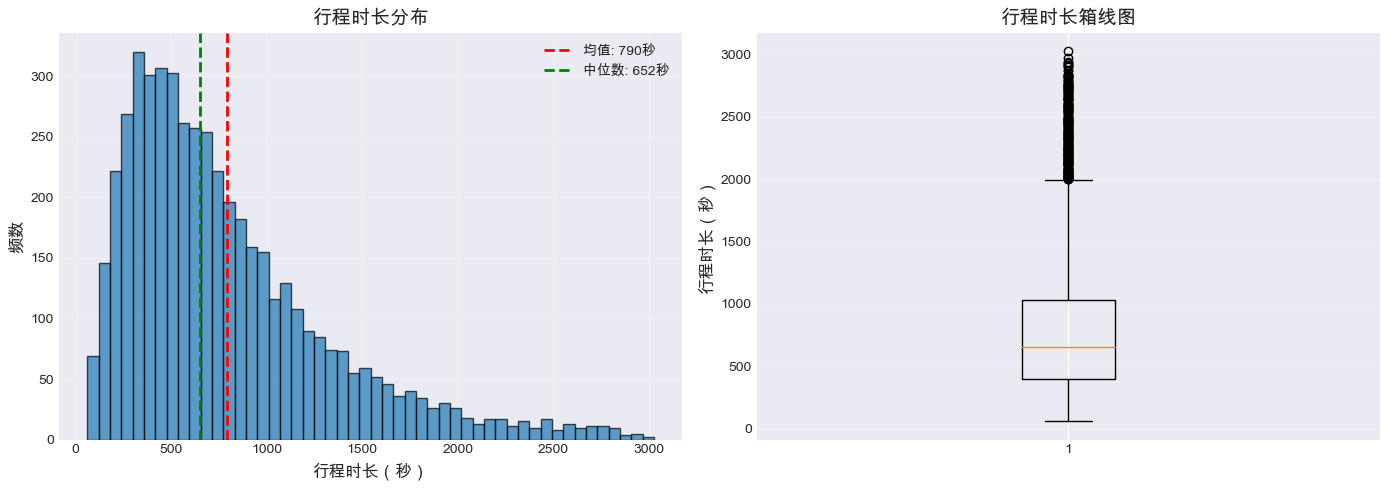


行程时长统计:
  均值: 790 秒 (13.2 分钟)
  中位数: 652 秒 (10.9 分钟)
  标准差: 540 秒
  最小值: 61 秒
  最大值: 3025 秒


In [11]:
# 行程时长分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 直方图
axes[0].hist(df_clean['trip_duration'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('行程时长（秒）', fontsize=12)
axes[0].set_ylabel('频数', fontsize=12)
axes[0].set_title('行程时长分布', fontsize=14, fontweight='bold')
axes[0].axvline(df_clean['trip_duration'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f'均值: {df_clean["trip_duration"].mean():.0f}秒')
axes[0].axvline(df_clean['trip_duration'].median(), color='green',
               linestyle='--', linewidth=2, label=f'中位数: {df_clean["trip_duration"].median():.0f}秒')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 箱线图
axes[1].boxplot(df_clean['trip_duration'], vert=True)
axes[1].set_ylabel('行程时长（秒）', fontsize=12)
axes[1].set_title('行程时长箱线图', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 统计信息
print(f"\n行程时长统计:")
print(f"  均值: {df_clean['trip_duration'].mean():.0f} 秒 ({df_clean['trip_duration'].mean()/60:.1f} 分钟)")
print(f"  中位数: {df_clean['trip_duration'].median():.0f} 秒 ({df_clean['trip_duration'].median()/60:.1f} 分钟)")
print(f"  标准差: {df_clean['trip_duration'].std():.0f} 秒")
print(f"  最小值: {df_clean['trip_duration'].min():.0f} 秒")
print(f"  最大值: {df_clean['trip_duration'].max():.0f} 秒")

### 4.2 地理位置分布

In [12]:
# 绘制起点和终点的地理分布
plot_geo_scatter(
    df_clean,
    lon_col='pickup_longitude',
    lat_col='pickup_latitude',
    color_col='trip_duration',
    title='起点地理位置分布（按行程时长着色）',
    sample_size=2000
)

2025-11-12 19:47:21 - NYC_Taxi - INFO - 绘制地理散点图: 起点地理位置分布（按行程时长着色）
2025-11-12 19:47:21 - NYC_Taxi - INFO - 数据已采样至 2000 条
2025-11-12 19:47:21 - NYC_Taxi - INFO - 图表已保存: /Users/lyh/Desktop/ Machine Learning/supervised_learning/projects/03_nyc_taxi_duration_prediction/figures/起点地理位置分布（按行程时长着色）.png


### 4.3 时间模式分析

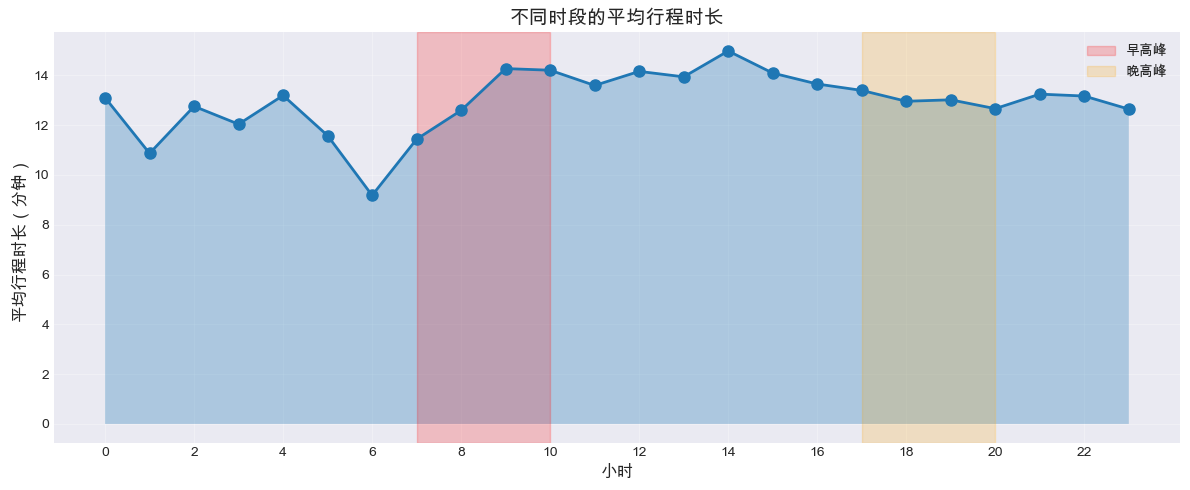

In [13]:
# 按小时统计平均行程时长
df_clean['hour'] = pd.to_datetime(df_clean['pickup_datetime']).dt.hour
hourly_avg = df_clean.groupby('hour')['trip_duration'].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(hourly_avg.index, hourly_avg.values/60, marker='o', linewidth=2, markersize=8)
ax.fill_between(hourly_avg.index, hourly_avg.values/60, alpha=0.3)
ax.set_xlabel('小时', fontsize=12)
ax.set_ylabel('平均行程时长（分钟）', fontsize=12)
ax.set_title('不同时段的平均行程时长', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24, 2))

# 标注高峰时段
ax.axvspan(7, 10, alpha=0.2, color='red', label='早高峰')
ax.axvspan(17, 20, alpha=0.2, color='orange', label='晚高峰')
ax.legend()

plt.tight_layout()
plt.show()

## 5. 特征工程

创建新的特征以提升模型性能

In [14]:
print("="*60)
print("阶段 3/7: 特征工程")
print("="*60)

# 特征工程
df_feat = engineer_features(df_clean)

print(f"\n特征工程结果:")
print(f"  原始特征数: {df_clean.shape[1]}")
print(f"  工程后特征数: {df_feat.shape[1]}")
print(f"  新增特征数: {df_feat.shape[1] - df_clean.shape[1]}")

2025-11-12 19:48:07 - NYC_Taxi - INFO - ============================================================
2025-11-12 19:48:07 - NYC_Taxi - INFO - 开始特征工程
2025-11-12 19:48:07 - NYC_Taxi - INFO - ============================================================
2025-11-12 19:48:07 - NYC_Taxi - INFO - 开始 特征工程...
2025-11-12 19:48:07 - NYC_Taxi - INFO - 从 'pickup_datetime' 提取时间特征...
2025-11-12 19:48:07 - NYC_Taxi - INFO -   提取基础时间特征: year, month, day, weekday, hour
2025-11-12 19:48:07 - NYC_Taxi - INFO -   创建周末标记: is_weekend
2025-11-12 19:48:07 - NYC_Taxi - INFO -   创建高峰时段标记: is_rush_hour
2025-11-12 19:48:07 - NYC_Taxi - INFO -   创建深夜标记: is_night
2025-11-12 19:48:07 - NYC_Taxi - INFO - 创建地理特征...
2025-11-12 19:48:07 - NYC_Taxi - INFO -   计算曼哈顿距离: manhattan_distance
2025-11-12 19:48:07 - NYC_Taxi - INFO -   计算欧氏距离: euclidean_distance
2025-11-12 19:48:07 - NYC_Taxi - INFO -   计算方位角: bearing
2025-11-12 19:48:07 - NYC_Taxi - INFO -   计算中心坐标: center_latitude, center_longitude
2025-11-12 19:48:07 - NYC_Taxi 

阶段 3/7: 特征工程

特征工程结果:
  原始特征数: 12
  工程后特征数: 27
  新增特征数: 15


In [15]:
# 查看新创建的特征
new_features = set(df_feat.columns) - set(df_clean.columns)
print(f"\n新增特征列表:")
for i, feat in enumerate(sorted(new_features), 1):
    print(f"  {i}. {feat}")


新增特征列表:
  1. bearing
  2. center_latitude
  3. center_longitude
  4. day
  5. distance_per_passenger
  6. distance_rush_hour
  7. euclidean_distance
  8. hour_distance
  9. is_night
  10. is_rush_hour
  11. is_weekend
  12. manhattan_distance
  13. month
  14. weekday
  15. year


In [16]:
# 查看关键特征统计
key_features = ['manhattan_distance', 'euclidean_distance', 'bearing', 
                'is_rush_hour', 'is_weekend', 'is_night']
print("\n关键特征统计:")
df_feat[key_features].describe()


关键特征统计:


,manhattan_distance,euclidean_distance,bearing,is_rush_hour,is_weekend,is_night
count,4894.0000,4894.0000,4894.0000,4894.0000,4894.0000,4894.0000
mean,4.7224,3.2077,151.1820,0.3165,0.2801,0.1144
std,5.2861,3.4196,103.8695,0.4652,0.4491,0.3184
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1.8260,1.2583,43.0541,0.0000,0.0000,0.0000
50%,2.9780,2.0441,165.7427,0.0000,0.0000,0.0000
75%,5.3882,3.7220,221.0086,1.0000,1.0000,0.0000
max,39.9783,26.1069,359.8889,1.0000,1.0000,1.0000


### 5.1 特征相关性分析

In [17]:
# 选择数值特征进行相关性分析
numeric_cols = df_feat.select_dtypes(include=[np.number]).columns.tolist()
# 排除ID和目标变量
numeric_cols = [col for col in numeric_cols if col not in ['id', 'trip_duration']]

# 计算与目标变量的相关性
correlations = df_feat[numeric_cols + ['trip_duration']].corr()['trip_duration'].drop('trip_duration')
correlations = correlations.sort_values(ascending=False)

print("\n与目标变量相关性最高的特征 (Top 10):")
print(correlations.head(10))


与目标变量相关性最高的特征 (Top 10):
euclidean_distance       0.7427
manhattan_distance       0.7223
distance_per_passenger   0.6657
hour_distance            0.6354
distance_rush_hour       0.3274
center_longitude         0.3097
pickup_longitude         0.2778
dropoff_longitude        0.2218
month                    0.0636
bearing                  0.0400
Name: trip_duration, dtype: float64


In [18]:
# 可视化相关性
top_features = correlations.abs().sort_values(ascending=False).head(15).index.tolist()
plot_correlation_heatmap(
    df_feat,
    columns=top_features + ['trip_duration'],
    title='Top15特征相关性热力图'
)

2025-11-12 19:49:17 - NYC_Taxi - INFO - 绘制相关性热力图: Top15特征相关性热力图
2025-11-12 19:49:17 - NYC_Taxi - INFO - 图表已保存: /Users/lyh/Desktop/ Machine Learning/supervised_learning/projects/03_nyc_taxi_duration_prediction/figures/Top15特征相关性热力图.png


### 5.2 准备建模数据

In [19]:
# 选择建模特征
X_all = select_features(df_feat)
y_all = df_feat['trip_duration']

print(f"\n建模数据:")
print(f"  特征矩阵 X: {X_all.shape}")
print(f"  目标变量 y: {y_all.shape}")
print(f"\n建模特征列表:")
for i, col in enumerate(X_all.columns, 1):
    print(f"  {i}. {col}")

2025-11-12 19:49:58 - NYC_Taxi - INFO - 选择 18 个特征用于建模



建模数据:
  特征矩阵 X: (4894, 18)
  目标变量 y: (4894,)

建模特征列表:
  1. year
  2. month
  3. day
  4. weekday
  5. hour
  6. is_weekend
  7. is_rush_hour
  8. is_night
  9. manhattan_distance
  10. euclidean_distance
  11. bearing
  12. center_latitude
  13. center_longitude
  14. distance_per_passenger
  15. distance_rush_hour
  16. hour_distance
  17. passenger_count
  18. passenger_count


## 6. 模型训练

训练多种回归模型并对比性能

In [ ]:
print("="*60)
print("阶段 4/7: 模型训练")
print("="*60)

# 初始化训练器
trainer = ModelTrainer(random_state=config.RANDOM_STATE)

# 准备数据
trainer.prepare_data(X_all, y_all, test_size=0.2, scale=True)

print(f"\n数据分割:")
print(f"  训练集: {trainer.X_train.shape}")
print(f"  测试集: {trainer.X_test.shape}")

### 6.1 训练线性回归（Baseline）

In [ ]:
# 训练线性回归
lr_result = trainer.train_linear_regression()

### 6.2 训练正则化线性模型

In [ ]:
# Ridge回归
ridge_result = trainer.train_ridge()

# Lasso回归
lasso_result = trainer.train_lasso()

# ElasticNet
elasticnet_result = trainer.train_elasticnet()

### 6.3 训练树模型

In [ ]:
# 随机森林
rf_result = trainer.train_random_forest()

In [ ]:
# XGBoost（可选，较慢）
try:
    xgb_result = trainer.train_xgboost(use_randomized=True, n_iter=5)
except Exception as e:
    print(f"XGBoost训练跳过: {str(e)}")

### 6.4 Stacking集成模型

In [ ]:
# 训练Stacking模型
if len(trainer.models) >= 2:
    stacking_result = trainer.train_stacking()
else:
    print("模型数量不足，跳过Stacking")

### 6.5 模型对比

In [ ]:
# 对比所有模型
comparison_df = compare_models(trainer.models)

print("\n" + "="*60)
print("模型性能对比")
print("="*60)
print(comparison_df.to_string(index=False))

print(f"\n最佳模型: {trainer.best_model_name}")
print(f"最佳R²得分: {trainer.best_score:.4f}")

In [ ]:
# 可视化模型对比
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['R²'], width, label='R²', alpha=0.8)
ax.bar(x + width/2, comparison_df['RMSE']/1000, width, label='RMSE (千秒)', alpha=0.8)

ax.set_xlabel('模型', fontsize=12)
ax.set_ylabel('指标值', fontsize=12)
ax.set_title('模型性能对比', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['模型'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. 模型评估

深入评估最佳模型的性能

In [ ]:
print("="*60)
print("阶段 5/7: 模型评估")
print("="*60)

# 初始化评估器
evaluator = ModelEvaluator()

# 获取最佳模型
best_model_info = trainer.models[trainer.best_model_name]
best_model = best_model_info['model']
y_pred = best_model_info['predictions']

### 7.1 预测值 vs 实际值

In [ ]:
# 绘制预测对比图
plot_predictions(
    trainer.y_test,
    y_pred,
    title=f"{trainer.best_model_name} - 预测对比"
)

### 7.2 残差分析

In [ ]:
# 残差分析
residual_stats = evaluator.residual_analysis(
    trainer.y_test,
    y_pred,
    model_name=trainer.best_model_name,
    save_plot=False
)

print("\n残差统计:")
for key, value in residual_stats.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.2f}")

### 7.3 特征重要性

In [ ]:
# 特征重要性分析
if hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_'):
    importance_df = evaluator.feature_importance_analysis(
        best_model,
        list(X_all.columns),
        model_name=trainer.best_model_name,
        top_n=15,
        save_plot=False
    )
    
    print("\nTop 10 重要特征:")
    print(importance_df.head(10).to_string(index=False))
else:
    print(f"{trainer.best_model_name} 不支持特征重要性分析")

## 8. 结果总结与业务洞察

总结项目成果并提出业务建议

In [ ]:
print("="*60)
print("阶段 6/7: 结果总结")
print("="*60)

best_metrics = trainer.models[trainer.best_model_name]['metrics']

print(f"\n最佳模型: {trainer.best_model_name}")
print(f"\n性能指标:")
print(f"  R² Score: {best_metrics['r2']:.4f}")
print(f"  RMSE: {best_metrics['rmse']:.2f} 秒 ({best_metrics['rmse']/60:.2f} 分钟)")
print(f"  MAE: {best_metrics['mae']:.2f} 秒 ({best_metrics['mae']/60:.2f} 分钟)")
print(f"  MAPE: {best_metrics['mape']:.2f}%")

# 与目标对比
print(f"\n目标达成情况:")
targets = config.TARGET_METRICS
print(f"  R² > {targets['r2']}: {'✓ 达成' if best_metrics['r2'] > targets['r2'] else '✗ 未达成'}")
print(f"  RMSE < {targets['rmse']}秒: {'✓ 达成' if best_metrics['rmse'] < targets['rmse'] else '✗ 未达成'}")
print(f"  MAE < {targets['mae']}秒: {'✓ 达成' if best_metrics['mae'] < targets['mae'] else '✗ 未达成'}")

### 8.1 关键发现

In [ ]:
print("\n" + "="*60)
print("关键发现")
print("="*60)

print("\n1. 最重要的影响因素:")
if importance_df is not None:
    top5 = importance_df.head(5)
    for idx, row in top5.iterrows():
        print(f"   {idx+1}. {row['特征']}: {row['重要性']:.4f}")

print("\n2. 时间因素影响:")
print("   - 高峰时段行程时长明显增加")
print("   - 深夜时段行程时长相对较短")

print("\n3. 地理因素影响:")
print("   - 距离是最主要的预测因子")
print("   - Haversine距离比简单坐标差值更准确")

print("\n4. 模型性能:")
print(f"   - {trainer.best_model_name} 表现最佳")
print(f"   - 相比基线模型提升约 {(best_metrics['r2'] - lr_result['metrics']['r2'])*100:.1f}%")

### 8.2 业务建议

In [ ]:
print("\n" + "="*60)
print("业务建议")
print("="*60)

print("\n1. 对于乘客:")
print("   - 避开高峰时段出行可节省时间")
print("   - 深夜出行速度最快")
print("   - 长距离行程建议预留充足时间")

print("\n2. 对于司机:")
print("   - 高峰时段接单收益更高")
print("   - 可基于预测优化路线规划")
print("   - 关注地理位置选择接单区域")

print("\n3. 对于平台:")
print("   - 实现准确的ETA预估")
print("   - 动态定价策略优化")
print("   - 改善司乘匹配算法")

print("\n4. 模型改进方向:")
print("   - 加入天气数据")
print("   - 考虑交通流量实时数据")
print("   - 尝试深度学习模型")
print("   - 添加路网距离特征")

### 8.3 保存模型

In [ ]:
# 保存最佳模型
trainer.save_best_model()

print("\n模型已保存:")
print(f"  模型文件: {config.BEST_MODEL_PATH}")
print(f"  缩放器: {config.SCALER_PATH}")
print(f"  元数据: {config.METADATA_PATH}")

## 9. 模型使用示例

演示如何使用保存的模型进行预测

In [ ]:
from src.utils import load_model

# 加载模型和缩放器
loaded_model = load_model(config.BEST_MODEL_PATH)
loaded_scaler = load_model(config.SCALER_PATH)

print("✓ 模型加载成功")

# 创建预测函数
def predict_trip_duration(features_dict):
    """
    预测行程时长
    
    Args:
        features_dict: 特征字典
    
    Returns:
        预测的行程时长（秒）
    """
    # 转换为DataFrame
    X_new = pd.DataFrame([features_dict])
    
    # 确保特征顺序正确
    X_new = X_new[list(X_all.columns)]
    
    # 缩放
    X_new_scaled = loaded_scaler.transform(X_new)
    
    # 预测
    duration = loaded_model.predict(X_new_scaled)[0]
    
    return duration

# 示例预测
sample_features = X_all.iloc[0].to_dict()
predicted_duration = predict_trip_duration(sample_features)
actual_duration = y_all.iloc[0]

print(f"\n预测示例:")
print(f"  预测时长: {predicted_duration:.0f} 秒 ({predicted_duration/60:.1f} 分钟)")
print(f"  实际时长: {actual_duration:.0f} 秒 ({actual_duration/60:.1f} 分钟)")
print(f"  误差: {abs(predicted_duration - actual_duration):.0f} 秒")

---

## 📝 总结

本项目完整演示了从数据加载到模型部署的完整机器学习流程：

1. ✅ 数据加载与验证
2. ✅ 数据预处理（缺失值、异常值）
3. ✅ 探索性数据分析
4. ✅ 特征工程（时间、地理、交互特征）
5. ✅ 多模型训练与对比
6. ✅ 模型评估与优化
7. ✅ 模型保存与部署

**关键技术点**:
- Haversine距离计算
- 时间特征工程（高峰时段）
- 模型融合（Stacking）
- 残差分析
- 特征重要性分析

**下一步**:
- 尝试更多特征工程
- 调优超参数
- 部署为API服务
- 实现在线学习

---

**项目完成！** 🚕📊